In [229]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [230]:
#Defin the class value
class Value:
    
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self,other):
        
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward  
        
        return out
    
    def __rmul__(self, other): 
        return self * other
    
    def __truediv__(self, other): 
        return self * other**-1
    
    def __neg__(self): 
        return self * -1
    
    def __sub__(self, other): 
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad +=  (1 - t*t) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [231]:
from graphviz import Digraph

def trace(root):
    
    nodes, edges = set(), set()
    
    def build(v):
        
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'%rankdir': 'LR'})
    
    nodes, edges = trace(root)
    
    for n in nodes:
        
        uid = str(id(n))
        
        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            
            dot.node(name = uid + n._op, label=n._op)
            
            dot.edge(uid + n._op, uid)
         
    for n1,n2 in edges:
        
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [232]:
a = Value(4.0)
b = Value(2.0)
a / b

Value(data=2.0)

In [233]:
#Write a fuction
#Inputs x1 and x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#Weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(8.0, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#Return tanh
o = n.tanh(); o.label = 'o'


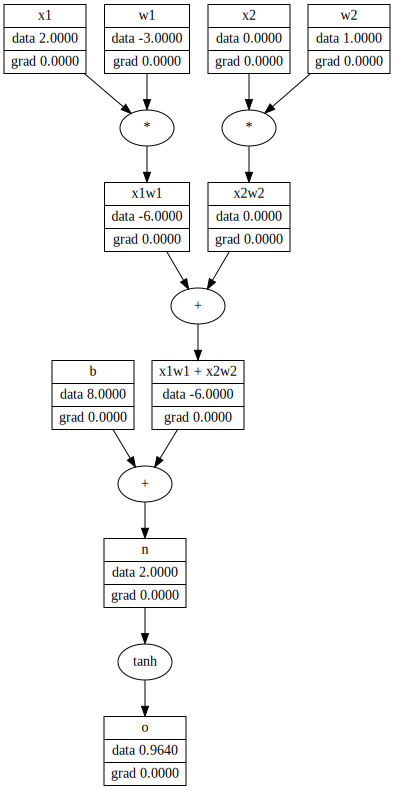

In [234]:
draw_dot(o)

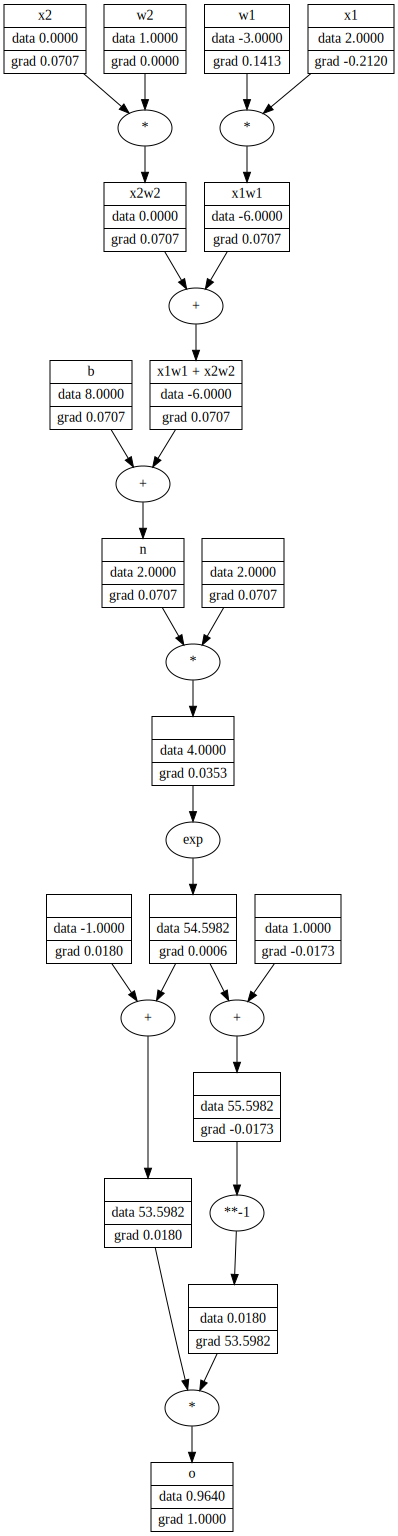

In [235]:
#Write a fuction
#Inputs x1 and x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#Weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(8.0, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#____
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'

o.backward()
draw_dot(o)


In [236]:
# Using PyTorch
import torch
import random

In [237]:
x1 = torch.Tensor([2.0]).double() ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [238]:
#Now we build NN 
class Neuron:
    
    def __init__(self,nin):
        
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
#Define the Layes
class Layer:
    
    def __init__(self,nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    
#Define multi layer perseptron
class MLP:
    
    def __init__(self, nin, nouts):
        
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        
        for layer in self.layers:
            x = layer(x)
        return x
    

In [239]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.6688108753885251)

In [240]:
#Example Dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0,-1.0, -1.0, 1.0]


ypred = [n(x) for x in xs]
ypred

[Value(data=-0.6688108753885251),
 Value(data=-0.543079007869474),
 Value(data=-0.6356452685222542),
 Value(data=-0.579041352070065)]

In [248]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=2.7849297378150157),
 Value(data=0.20877679304954416),
 Value(data=0.13275437035022022),
 Value(data=2.493371591547259)]

In [249]:
#This is replaced by the cells below
#loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [250]:
loss = Value(0.0)
for new_item in [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]:
    loss = loss + new_item     

In [251]:
loss

Value(data=5.619832492762039)

In [252]:
loss.backward()

In [253]:
n.layers[0].neurons[0].w[0].grad

-6.850508171507903

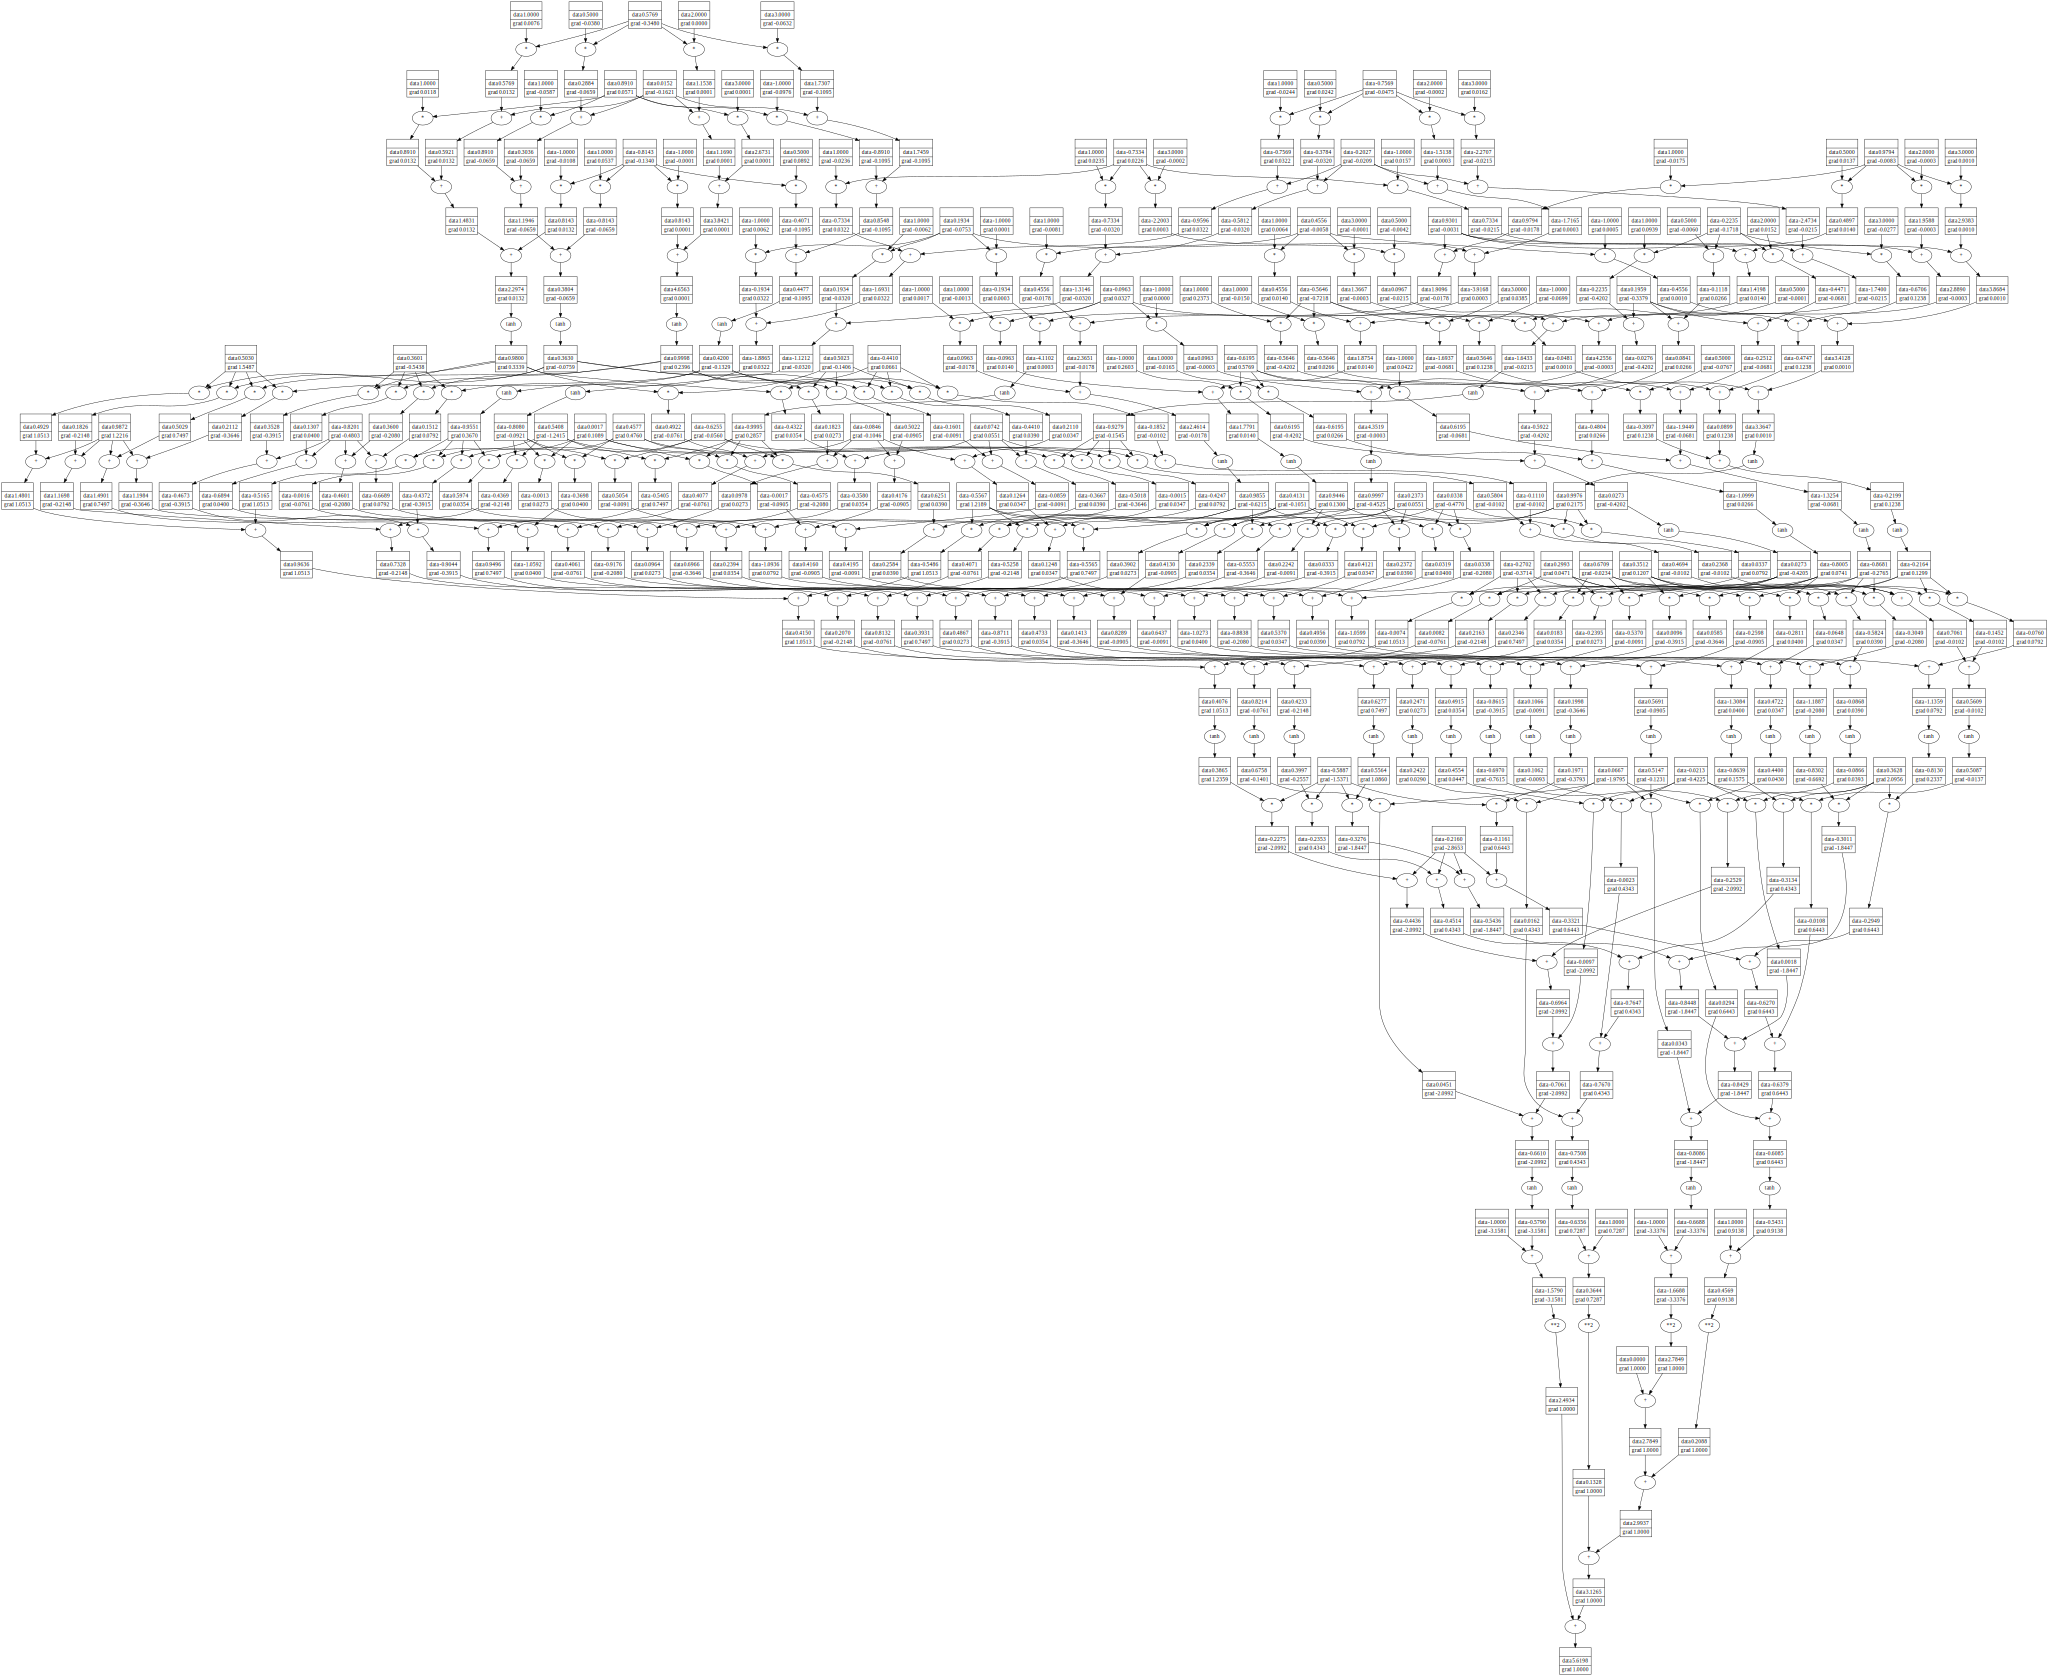

In [247]:
draw_dot(loss)